# PyESP tutorial
This notebook will show you how to get PyESP running on your computer and how to use it to simulate cyclic voltammograms.

## Compilation of the C extension
Unfortunately, you have to compile the C extension yourself. (If someone knows how to distribute Python extensions, please contact me!)

First: in a terminal (or command prompt) navigate to the directory where you've unpacked the source code and run the following command:

`python3 setup.py build_ext --inplace`

On my Ubuntu system, I get the following output:<br>
`running build_ext
building 'PyESP' extension
creating build
creating build/temp.linux-x86_64-3.7
gcc -pthread -B /home/limhes/anaconda3/compiler_compat -Wl,--sysroot=/ -Wsign-compare -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -fPIC -I/home/limhes/anaconda3/include/python3.7m -c PyESP.c -o build/temp.linux-x86_64-3.7/PyESP.o
gcc -pthread -B /home/limhes/anaconda3/compiler_compat -Wl,--sysroot=/ -Wsign-compare -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -fPIC -I/home/limhes/anaconda3/include/python3.7m -c simulate.c -o build/temp.linux-x86_64-3.7/simulate.o
creating build/lib.linux-x86_64-3.7
gcc -pthread -shared -B /home/limhes/anaconda3/compiler_compat -L/home/limhes/anaconda3/lib -Wl,-rpath=/home/limhes/anaconda3/lib -Wl,--no-as-needed -Wl,--sysroot=/ build/temp.linux-x86_64-3.7/PyESP.o build/temp.linux-x86_64-3.7/simulate.o -o build/lib.linux-x86_64-3.7/PyESP.cpython-37m-x86_64-linux-gnu.so
copying build/lib.linux-x86_64-3.7/PyESP.cpython-37m-x86_64-linux-gnu.so -> `

It's all pretty basic C stuff, so you shouldn't need to install anything.

## Using the extension
To use PyESP, just import it (or compile it first if it cannot import it yet). We will also use the math library and matplotlib.

In [5]:
try:
    import PyESP
except:
    import os
    os.system('python3 setup.py build_ext --inplace')
    import PyESP
import math
import matplotlib.pyplot as plt
plt.style.use('ggplot')

Next, we will set up the simulator and set simulation parameters. A full overview of the parameters and their units can be found on the original ESP webpage: http://lem.ch.unito.it/chemistry/esp_manual.html

In [6]:
PyESP.setup() # you need to call this before anything else
step_potential = 0.002 # the step potential in volts
PyESP.set_params( SI=int(step_potential*1000.) ) # set the "step increment", which is in millivolts (ESP parameter SI)
PyESP.set_params( AM=1, AP=0 ) # set AM (aqcuisition mode) and AP (approximation for chemical reactions on/off)

Now we start defining the chemistry. Let's go for an EC mechanism (an **E**lectrochemical step followed by a **C**hemical step):
1. Electrochemical step: A + e <-> B with potential E0 (in millivolts), heterogeneous rate constant (Butler-Volmer) k0 (in cm/s) and symmetry parameter alpha (between 0 and 1)
2. Chemical step: B <-> C with forward and backward rate constants kf and kb (in 1/s)

First, we add species A, B and C to the system, starting with a non-zero concentration (in mM) only for A, and with standard diffusion constants of 10e-5 cm2/s.

In [7]:
A = PyESP.addSpecies(1.0, 1.0e-5)
B = PyESP.addSpecies(0.0, 1.0e-5)
C = PyESP.addSpecies(0.0, 1.0e-5)

Then, we define the redox and chemical reactivity:

In [8]:
redox1 = PyESP.addRedox(A, B, 1, -200, 1e3, 0.5) # ox, red, n, E0 (mV), k0 (cm/s), alpha)
chem1 = PyESP.addChemical(B, 0, C, 0, 10., 0.) # species 1&2 left-hand-side, species 1&2 right-hand-side, kf&kb (1/s)

Then, we run the simulation for 5 different scan rates (because we can!) and plot the current divided by the square root of the scan rate (to scale the voltammograms):

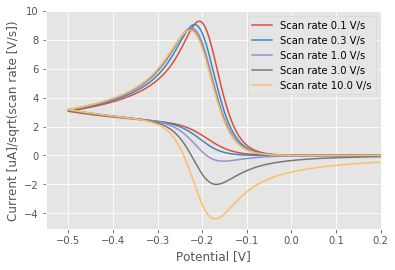

In [9]:
for scan_rate in [0.1, 0.3, 1.0, 3.0, 10.]:
    PyESP.set_params(ST=step_potential/scan_rate)
    [potential, current] = PyESP.simulate()
    plt.plot(potential, [i*1.0e6/math.sqrt(scan_rate) for i in current], label='Scan rate {:.1f} V/s'.format(scan_rate))

plt.xlabel('Potential [V]')
plt.ylabel('Current [uA]/sqrt(scan rate [V/s])')
plt.xlim(-0.55, 0.2)
plt.legend()
plt.show()

Lastly, we destroy the PyESP object. This is necessary to avoid memory leaks.

In [10]:
PyESP.destroy()